# Dynamics of an End-mirror QOM System using Functional Programming

In this notebook, the following topics are covered:

* The Heisenberg-Langevin Equations (HLEs)
* The Quantum Optomechanics (QOM) Toolbox
* Interfacing the System Class with the QOM Toolbox
* Simulating the Classical Equations of Motion (CEMs)
* Simulting the Correlations between the Quantum Fluctuations

## The Heisenberg-Langevin Equations (HLEs)

The Hamiltonian of a simple optomechanical system can be written as (refer to [our tutorial](https://arxiv.org/abs/2211.02596) for its derivation):
$$
H = - \hbar \Delta_{0} a^{\dagger} a + \hbar \omega_{m} b^{\dagger} b - \hbar g_{0} a^{\dagger} a \left( b^{\dagger} + b \right) + i \hbar A_{l} \left( a^{\dagger} - a \right),
$$
where $a$ ($b$) is the annihilation operator of the optical (mechanical) mode, $\Delta_{0}$ is the laser detuning, $\omega_{m}$ the mechanical resonance frequency, $g_{0}$ the optomechanical interaction strength and $A_{l}$ the laser amplitude.

In the linearized limit, this Hamiltonian can be:
* Classical complex-valued modes ($\alpha$, $\beta$) obeying coupled differential equations.
* Quantum real-valued quadratures ($X$, $Y$, $Q$, $P$) whose correlations obey a simple matrix equation.

The coupled differential equations are
$$
\frac{d \alpha}{d \tau} = - \left( \frac{\kappa^{\prime}}{2} - i \Delta_{0}^{\prime} \right) \alpha + i g_{0}^{\prime} \alpha \left( \beta^{*} + \beta \right) + A_{l}^{\prime}, \\
\frac{d \beta}{d \tau} = - \left( \frac{\gamma^{\prime}}{2} + i \right) \beta + i g_{0}^{\prime} \alpha^{*} \alpha,
$$
where $\kappa$ ($\gamma$) are the optical decay (mechanical damping) rates.
The prime superscript denotes normalization with $\omega_{m}$ with $\tau = \omega_{m} t$.

The equation of the quadrature correlation can be simplified as
$$
\frac{d \mathbf{V}}{d \tau} = \mathbf{A}^{\prime} \mathbf{V} + \mathbf{V} \mathbf{A}^{\prime T} + \mathbf{D}^{\prime},
$$
where $\mathbf{V}_{jk} = \frac{1}{2} \langle u_{j} u_{k} + u_{k} u_{j} \rangle$, with $\mathbf{u} = (X, Y, Q, P)^{T}$, the normalized noise matrix $\mathbf{D}^{\prime} = \mathrm{Diag}[\kappa^{\prime} / 2, \kappa^{\prime} / 2, \gamma^{\prime} (n_{th} + 1 / 2), \gamma^{\prime} (n_{th} + 1 / 2)]$ with $n_{th}$ being the thermal mechanical vibration quanta, and the normalized drift matrix $\mathbf{A}^{\prime}$ is
$$
\begin{pmatrix}
    - \frac{\kappa^{\prime}}{2} & - \Delta^{\prime} & - 2 G_{0I}^{\prime} & 0 \\
    \Delta^{\prime} & - \frac{\kappa^{\prime}}{2} & 2 G_{0R}^{\prime} & 0 \\
    0 & 0 & - \frac{\gamma^{\prime}}{2} & \omega_{m}^{\prime} \\
    2 G_{0R}^{\prime} & 2 G_{0I}^{\prime} & - \omega_{m}^{\prime} & - \frac{\gamma^{\prime}}{2}
\end{pmatrix},
$$
where $\Delta^{\prime} = \Delta_{0}^{\prime} + g_{0}^{\prime} ( \beta^{*} + \beta )$ and $G_{0R}^{\prime}$ ($G_{0I}^{\prime}$) are the real (imaginary) parts of $G_{0}^{\prime} = g_{0}^{\prime} \alpha$.

## The Quantum Optomechanics (QOM) Toolbox 

The Quantum Optomechanics Toolbox, packaged as [`qom`](https://github.com/sampreet/qom), is a wrapper-styled toolbox to simulate the classical and quantum dynamics of optomechanical models in a scalable manner.
Its key features include:
* Automatically managed loops and parameter validation modules.
* Solver modules to calculate classical and quantum signatures.
* Inheritable optomechanical systems supporting callable properties.
* Configurable visualizations without the need for explicit plotting.

Let's initialize the library...

In [1]:
# qom modules
from qom.ui import init_log
# initialize log
init_log()

MainThread               INFO    2022-11-16 20:10:24.350: (qom.ui.log) -------------------------------------------------Logger Initialized


## Interfacing the System Class with the QOM Toolbox

To simulate the classical mode amplitudes and the quantum correlations for the above system, we interface three functions for:
* the drift matrix of the quantum fluctuations,
* the initial values of the modes, correlations, noise matrix and the constant parameters, and
* the rate of change of each mode given by the coupled differential equations.

We then interface these functions to the respective `get_ivc` and `get_mode_rates` methods of one of the classes `BaseSystem` (parent system), `SOSMSystem` (inherited system for single optical and single mechanical mode), `SODMSystem` (inherited system for single optical and double mechanical mode), `DOSMSystem` (inherited system for double optical and single mechanical mode), `DODMSystem` (inherited system for double optical and double mechanical mode) and `SOMASystem` (inherited system for an array with single optical and mechanical modes).

The following script demonstrates this using the `SOSMSystem` class to interface our system.

In [2]:
####################################################################################                              DEPENDENCIES                              ####
################################################################################

# dependencies
import logging
import numpy as np

# qom modules
from qom.systems import SOSMSystem
from qom.ui.plotters import MPLPlotter

####################################################################################                               FUNCTIONS                                ####
################################################################################

# function to obtain the normalized drift matrix
def func_A(modes, params, t=None):
    # extract frequently used variables
    A_l_norm, Delta_0_norm, g_0_norm, gamma_norm, kappa_norm = params
    alpha, beta = modes

    # effective values
    Delta_norm = Delta_0_norm + 2 * g_0_norm * np.real(beta)
    g_norm = g_0_norm * alpha

    # drift matrix
    A_norm = np.zeros((4, 4), dtype=np.float_)
    # X quadratures
    A_norm[0][0] = - kappa_norm / 2
    A_norm[0][1] = - Delta_norm
    A_norm[0][2] = - 2 * np.imag(g_norm)
    # Y quadratures
    A_norm[1][0] = Delta_norm
    A_norm[1][1] = - kappa_norm / 2
    A_norm[1][2] = 2 * np.real(g_norm)
    # Q quadratures
    A_norm[2][2] = - gamma_norm / 2
    A_norm[2][3] = 1.0
    # P quadratures
    A_norm[3][0] = 2 * np.real(g_norm)
    A_norm[3][1] = 2 * np.imag(g_norm)
    A_norm[3][2] = - 1.0
    A_norm[3][3] = - gamma_norm / 2

    return A_norm

# function to obtain the intial values and constants
def func_ivc():
    # extract frequently used variables
    A_l_norm       = 25.0
    Delta_0_norm   = -1.0
    g_0_norm       = 0.005
    gamma_norm     = 0.005
    kappa_norm     = 0.15
    n_th            = 0.0

    # initial mode values as 1D list
    modes_0 = np.zeros(2, dtype=np.complex_).tolist()
    
    # normalized parameters
    c_params = [A_l_norm, Delta_0_norm, g_0_norm, gamma_norm, kappa_norm]

    # # uncomment this block to simulate only classical mode amplitudes
    # return modes_0, c_params

    # initial quadrature correlations
    corrs_0 = np.zeros((4, 4), dtype=np.float_)
    corrs_0[0][0] = 0.5
    corrs_0[1][1] = 0.5
    corrs_0[2][2] = n_th + 0.5
    corrs_0[3][3] = n_th + 0.5

    # convert to 1D list and concatenate all variables
    iv = modes_0 + [np.complex_(element) for element in corrs_0.flatten()]

    # normalized noise correlation matrix
    D_norm = np.zeros((4, 4), dtype=np.float_)
    D_norm[0][0] = kappa_norm / 2
    D_norm[1][1] = kappa_norm / 2
    D_norm[2][2] = gamma_norm * (2 * n_th + 1) / 2
    D_norm[3][3] = gamma_norm * (2 * n_th + 1) / 2

    # all constants
    c = D_norm.flatten().tolist() + c_params

    return iv, c

# function to obtain the rates of the optical and mechanical modes.
def func_mode_rates(modes, params, t=None):
    # extract frequently used variables
    A_l_norm, Delta_0_norm, g_0_norm, gamma_norm, kappa_norm = params
    alpha, beta = modes

    # effective detuning
    Delta_norm = Delta_0_norm + 2 * g_0_norm * np.real(beta)

    # calculate mode rates
    dalpha_dt = - kappa_norm / 2 * alpha + 1j * Delta_norm * alpha + A_l_norm
    dbeta_dt = 1j * g_0_norm * np.conjugate(alpha) * alpha - gamma_norm / 2 * beta - 1j * beta
    # normalize
    mode_rates = [dalpha_dt, dbeta_dt]

    return mode_rates
    
####################################################################################                                SYSTEM                                  ####
################################################################################

# initialize logger
init_log()
logger = logging.getLogger('qom.examples')

# initialize system
system = SOSMSystem()
# set the functions to appropriate methods
system.get_A = func_A
system.get_ivc = func_ivc
system.get_mode_rates = func_mode_rates

## Simulating the Classical Equations of Motion (CEM)

The `get_modes_corrs_dynamics` or the `get_modes_corrs_stationary` methods can be used to obtain the dynamical values or the stationary values of the modes.
Alternatively, the `get_measure_dynamics` or the `get_measure_stationary` methods can also be used with `"measure_type"` set to `"mode_amp"` and `"idx_e"` set to `[0, 1]` (`0` and `1` represent the indices of the modes $\alpha$ and $\beta$).

Below, we obtain and compare the dynamical and stationary values of the classical mode amplitudes.

MainThread               INFO    2022-11-16 20:10:27.134: (qom.solvers.HLESolver) ----------------------------------------Results Obtained	
MainThread               INFO    2022-11-16 20:10:27.254: (qom.systems.BaseSystem) --------------------------------------Measures Obtained	


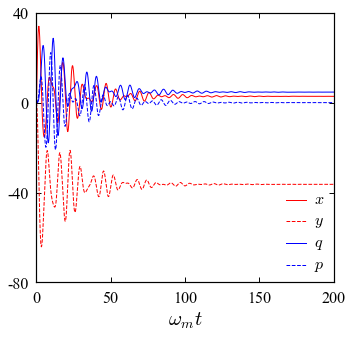

MainThread               INFO    2022-11-16 20:10:27.844: (qom.examples) ------------------------------------Stationary value of x:   2.82
MainThread               INFO    2022-11-16 20:10:27.845: (qom.examples) ------------------------------------Stationary value of y: -36.35
MainThread               INFO    2022-11-16 20:10:27.846: (qom.examples) ------------------------------------Stationary value of q:   4.70
MainThread               INFO    2022-11-16 20:10:27.846: (qom.examples) ------------------------------------Stationary value of p:   0.01


In [3]:
####################################################################################                           DYNAMICAL VALUES                             ####
################################################################################

# parameters for the solver
solver_params = {
    'show_progress': True,
    'method': 'zvode',
    'cache': False,
    'measure_type': 'mode_amp',
    'idx_e': [0, 1],
    't_min': 0.0,
    't_max': 200.0,
    't_dim': 2001
}
# calculate dynamical values
Modes, T = system.get_measure_dynamics(solver_params=solver_params)
# # uncomment for alternative expression
# Modes, _, T = system.get_modes_corrs_dynamics(solver_params=solver_params)
# extract values
x_d = (np.sqrt(2) * np.real(np.transpose(Modes)[0])).tolist()
y_d = (np.sqrt(2) * np.imag(np.transpose(Modes)[0])).tolist()
q_d = (np.sqrt(2) * np.real(np.transpose(Modes)[1])).tolist()
p_d = (np.sqrt(2) * np.imag(np.transpose(Modes)[1])).tolist()
# display dynamical values
plotter = MPLPlotter(axes={
    'X': T,
    'Y': list(range(4))
}, params={
    'type': 'lines',
    'x_label': '$\\omega_{m} t$',
    'x_ticks': list(range(0, 201, 50)),
    'y_colors': ['r', 'r', 'b', 'b'],
    'y_styles': ['-', '--', '-', '--'],
    'y_legend': ['$x$', '$y$', '$q$', '$p$'],
    'v_ticks': list(range(-80, 41, 40)),
    'show_legend': True,
    'width': 5.0
})
plotter.update(xs=T, vs=[x_d, y_d, q_d, p_d])
plotter.show(hold=True)

####################################################################################                          STATIONARY VALUES                             ####
################################################################################

# parameters for the solver
solver_params = {
    'measure_type': 'mode_amp',
    'idx_e': [0, 1]
}
# calculate stationary values
modes = system.get_measure_stationary(solver_params=solver_params)
# # uncomment for alternative method
# modes, _ = system.get_modes_corrs_stationary(solver_params=solver_params)
# extract values
x_s = np.sqrt(2) * np.real(modes[0])
y_s = np.sqrt(2) * np.imag(modes[0])
q_s = np.sqrt(2) * np.real(modes[1])
p_s = np.sqrt(2) * np.imag(modes[1])
# display stationary values
logger.info('------------------------------------Stationary value of x: {:6.2f}\n'.format(x_s))
logger.info('------------------------------------Stationary value of y: {:6.2f}\n'.format(y_s))
logger.info('------------------------------------Stationary value of q: {:6.2f}\n'.format(q_s))
logger.info('------------------------------------Stationary value of p: {:6.2f}\n'.format(p_s))

We can also plot the phase-space trajectory of mechanical motion with the obtained dynamical values.

The following snippet illustrates this.
The final ($10 \times 2 \pi \omega_{m} t$) values are marked in red.

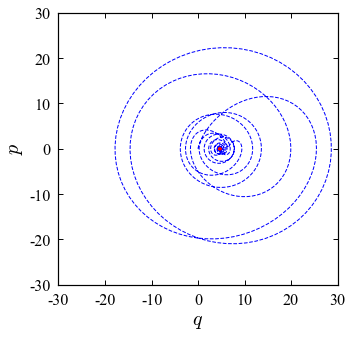

In [4]:
# display phase-space trajectory
plotter = MPLPlotter(axes={}, params={
    'type': 'lines',
    'x_label': '$q$',
    'x_ticks': list(range(-30, 31, 10)),
    'y_colors': ['b', 'r'],
    'y_sizes': [1, 2],
    'y_styles': ['--', '-'],
    'v_label': '$p$',
    'v_ticks': list(range(-30, 31, 10)),
    'width': 5.0
})
plotter.update(xs=[q_d, q_d[-628:]], vs=[p_d, p_d[-628:]])
plotter.show(True)

In the adiabatic limit ($\kappa \gg \gamma, g_{0}$), the classical modes can be expressed as stationary values 
$$
\alpha_{s} = \frac{A_{l}^{\prime}}{\frac{\kappa^{\prime}}{2} - i \Delta^{\prime}}, \\
\beta_{s} = \frac{i g_{0}^{\prime} \left| \alpha_{s} \right|^{2}}{\frac{\gamma^{\prime}}{2} + i}.
$$

These equations can be simplified as a cubic in $N_{o} = | \alpha_{s} |^{2}$ given by
$$
4 C^{\prime 2} N^{3} + 8 C^{\prime} \Delta_{0}^{\prime} N^{2} + \left( 4 \Delta_{0}^{\prime 2} + \kappa^{\prime 2} \right) N - 4 \left| A_{l}^{\prime} \right|^{2} = 0,
$$
where $C^{\prime} = 2 g_{0}^{\prime 2} / ( \gamma^{\prime 2} / 4 + 1 )$.

We can obtain the real solutions of this cubic equation which represent the values of $N_{o}$ by using the `get_mean_optical_occupancies` method.
This method requires the `get_oss_args` method defined for the system to obtain the parameters $A_{l}^{\prime}$, $\Delta_{0}^{\prime}$, $\kappa^{\prime}$ and $C^{\prime}$ defined in the cubic.

The following snippets illustrates the process of obtaining the mean optical occupancies.

In [5]:
# function to obtain the required parameters to calculate the optical steady state
def func_oss_args(params):
    # extract frequently used variables
    A_l_norm, Delta_0_norm, g_0_norm, gamma_norm, kappa_norm = params

    # coefficient of occupancy
    C_norm = 2 * g_0_norm**2 / (gamma_norm**2 / 4 + 1)
    
    return A_l_norm, Delta_0_norm, kappa_norm, C_norm

# add function to system method
system.get_oss_args = func_oss_args

# obtain and display mean optical occupancies
N_os, _ = system.get_mean_optical_occupancies()
logger.info('------------------------------------------Number of real roots: {}\n'.format(len(N_os)))
logger.info('N_os: {}\n'.format(N_os))

MainThread               INFO    2022-11-16 20:10:28.155: (qom.examples) ------------------------------------------Number of real roots: 3
MainThread               INFO    2022-11-16 20:10:28.156: (qom.examples) N_os: [22940.824128391057, 16394.715369270216, 664.7105023387211]


## Simulting the Correlations between the Quantum Fluctuations

The following script demonstrates the simulation of quantum correlations by calculating the dynamical and stationary values of the variances in position and momentum of the mechanical mode, which correspond to the elements $\mathbf{V}_{22}$ and $\mathbf{V}_{33}$ respectively.

MainThread               INFO    2022-11-16 20:10:28.236: (qom.systems.BaseSystem) --------------------------------------Measures Obtained	


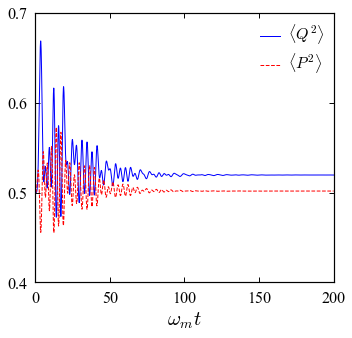

MainThread               INFO    2022-11-16 20:10:28.488: (qom.examples) -------------------Stationary value of Q_2_expect:   0.52
MainThread               INFO    2022-11-16 20:10:28.488: (qom.examples) -------------------Stationary value of P_2_expect:   0.50


In [6]:

####################################################################################                           DYNAMICAL VALUES                             ####
################################################################################

# parameters for the solver
solver_params = {
    'show_progress': True,
    'method': 'zvode',
    'cache': False,
    'measure_type': 'corr_ele',
    'idx_e': [(2, 2), (3, 3)],
    't_min': 0.0,
    't_max': 200.0,
    't_dim': 2001
}
# calculate dynamic values
Corrs, T = system.get_measure_dynamics(solver_params=solver_params)
# extract values
Q_2_expect_d = np.transpose(Corrs)[0].tolist()
P_2_expect_d = np.transpose(Corrs)[1].tolist()
# # uncomment for alternative expression
# _, Corrs, T = system.get_modes_corrs_dynamics(solver_params=solver_params)
# # extract values
# Q_2_expect_d = [corrs[2][2] for corrs in Corrs]
# P_2_expect_d = [corrs[3][3] for corrs in Corrs]
# display dynamical values
plotter = MPLPlotter(axes={
    'X': T,
    'Y': list(range(2))
}, params={
    'type': 'lines',
    'x_label': '$\\omega_{m} t$',
    'x_ticks': list(range(0, 201, 50)),
    'y_colors': ['b', 'r'],
    'y_styles': ['-', '--'],
    'y_legend': ['$\\langle Q^{2} \\rangle$', '$\\langle P^{2} \\rangle$'],
    'v_ticks': [0.4, 0.5, 0.6, 0.7],
    'show_legend': True,
    'width': 5.0
})
plotter.update(xs=T, vs=[Q_2_expect_d, P_2_expect_d])
plotter.show(hold=True)

####################################################################################                          STATIONARY VALUES                             ####
################################################################################

# parameters for the solver
solver_params = {
    'measure_type': 'corr_ele',
    'idx_e': [(2, 2), (3, 3)]
}
# calculate stationary values
corrs = system.get_measure_stationary(solver_params=solver_params)
# extract values
Q_2_expect_s = corrs[0]
P_2_expect_s = corrs[1]
# # uncomment for alternative method
# _, corrs = system.get_modes_corrs_stationary(solver_params=solver_params)
# # extract values
# Q_2_expect_s = corrs[2][2]
# P_2_expect_s = corrs[3][3]
# display stationary values
logger.info('-------------------Stationary value of Q_2_expect: {:6.2f}\n'.format(Q_2_expect_s))
logger.info('-------------------Stationary value of P_2_expect: {:6.2f}\n'.format(P_2_expect_s))

We can also calculate quantum properties like Entanglement, Phase Synchronization and Discord using the `get_measure_dynamics` method with their corresponding measure codes and one or more pairs of mode indices.

The following snippet illustrates the calculation of the logarithmic negativity measure of entanglement between the optical and mechanical modes.

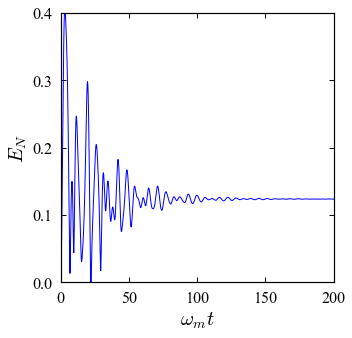

MainThread               INFO    2022-11-16 20:10:28.903: (qom.examples) ---------------------Stationary value of entan_ln:   0.12


In [7]:
# parameters for the solver
solver_params = {
    'measure_type': 'entan_ln',
    'idx_e': (0, 1)
}
# calculate and display dynamical value
Entan_ln, T = system.get_measure_dynamics(solver_params=solver_params)
plotter = MPLPlotter(axes={}, params={
    'type': 'lines',
    'x_label': '$\\omega_{m} t$',
    'x_ticks': list(range(0, 201, 50)),
    'y_colors': ['b'],
    'v_label': '$E_{N}$',
    'v_ticks': [0.0, 0.1, 0.2, 0.3, 0.4],
    'width': 5.0
})
plotter.update(xs=T, vs=np.transpose(Entan_ln)[0])
plotter.show(hold=True)
# calculate and display stationary value
entan_ln = system.get_measure_stationary(solver_params=solver_params)
logger.info('---------------------Stationary value of entan_ln: {:6.2f}\n'.format(entan_ln[0]))